In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import torch

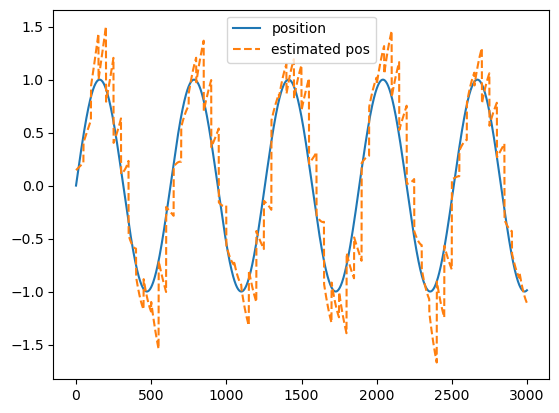

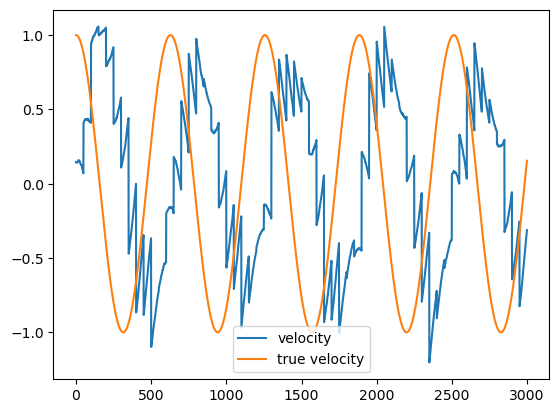

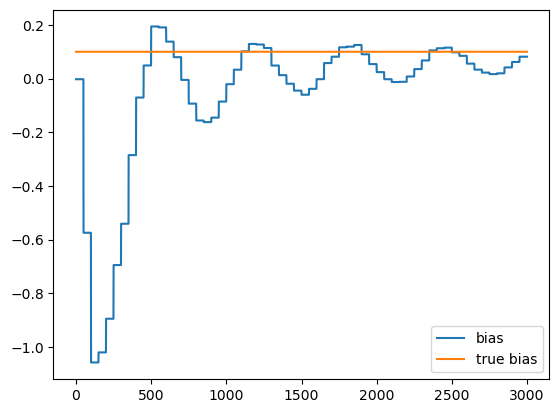

In [57]:
# define a small mlp network
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


A = [[0, 1, 0],
     [0, 0, -1],
     [0, 0, 0]]
B = [[0],
     [1],
     [0]]
C = [[1, 0, 0], [0, 1, 0]]
D = [[0], [0]]

# generate trajectory p(t)
end = 30
samples = end*100
t = np.linspace(0, end, samples)
p = np.sin(t)
v = np.cos(t)
a_bias = 0.1
a_noise = 0.2*np.random.randn(samples)
a = -np.sin(t) + a_bias + a_noise
yp = p + 0.1*np.random.randn(samples)
yp = torch.from_numpy(yp).float()

comb = np.concatenate([A, B], axis=1)
comb = np.concatenate([comb, np.zeros((1, 4))], axis=0)

dt = t[1] - t[0]
Ad = torch.from_numpy(la.expm(comb*dt)[:3, :3])
Bd = torch.from_numpy(la.expm(comb*dt)[:3, 3:]).float()

# Define the system matrices
F = Ad.float()

H = torch.from_numpy(np.array(C)).float()

# Process noise covariance
Q = torch.from_numpy(np.diag([2, 1, 0])).float()

# Measurement noise covariance
R = torch.from_numpy(np.diag([[0.05]])).float()

# Initial state estimate
x_hat = torch.from_numpy(np.array([[0], [.1], [0]])).float()

# Initial error covariance
P = torch.from_numpy(np.diag([1, 100, 1000])).float()

record = torch.from_numpy(np.zeros((len(p), 3))).float()

# Kalman Filter loop
for i in range(len(p)):
    # Predict step
    x_hat = F @ x_hat + Bd * a[i]
    P = F @ P @ F.T + Q

    # Update step
    if i % 50 == 0:
        K = P @ H.T @ torch.linalg.inv(H @ P @ H.T + R)
        x_hat = x_hat + K @ (yp[i] - H @ x_hat)
        P = (torch.eye(3) - K @ H) @ P

    record[i, :] = x_hat.T

# plt.figure(dpi=200)
plt.plot(p, label='position')
plt.plot(record[:, 0], label='estimated pos', linestyle='dashed')
# plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
plt.legend()
# velocity
plt.figure()
plt.plot(record[:, 1], label='velocity')
plt.plot(v, label='true velocity')
plt.legend()
plt.figure()
plt.plot(record[:, 2], label='bias')
plt.plot(np.ones(len(record))*a_bias, label='true bias')
plt.legend()

In [24]:
# the network will be used to predict process nosie covariance of a Kalman filter
# the input is the states+inputs of the system for a time window of size N
N = 10
np.random.seed(0)
torch.manual_seed(0)
input_size = (3+1)*N 
hidden_size = 128
output_size = 9
model = MLP(input_size, hidden_size, output_size)

learning_rate = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   

In [16]:
# x = [p,v,b_a]
# u = [a]
# y = [p]

A = [[0, 1, 0],
     [0, 0, -1],
     [0, 0, 0]]
B = [[0],
     [1],
     [0]]
C = [[1, 0, 0], [0, 1, 0]]
D = [[0], [0]]

# generate trajectory p(t)
end = 10
samples = end*100
p = np.sin(np.linspace(0, end, samples))
v = np.cos(np.linspace(0, end, samples))
a_bias = 0.1
a_noise = 0.2*np.random.randn(samples)
a = -np.sin(np.linspace(0, end, samples)) + a_bias + a_noise
yp = p + 0.1*np.random.randn(samples)
yp = np.vstack([yp, v + 0.05*np.random.randn(samples)])

comb = np.concatenate([A, B], axis=1)
comb = np.concatenate([comb, np.zeros((1, 4))], axis=0)

dt = 0.01
la.expm(comb*dt)
Ad = la.expm(comb*dt)[:3, :3]
Bd = la.expm(comb*dt)[:3, 3:]

Obs:  3


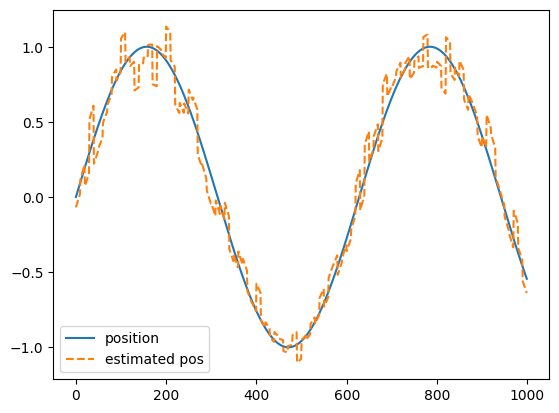

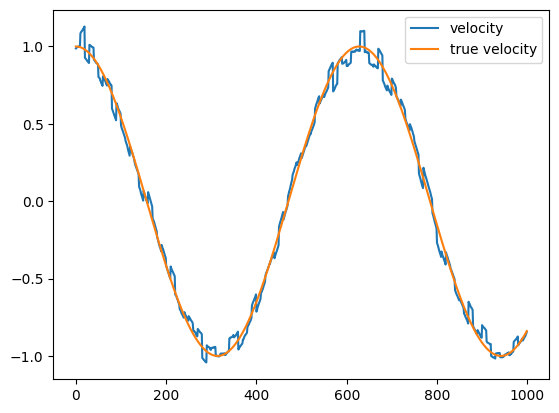

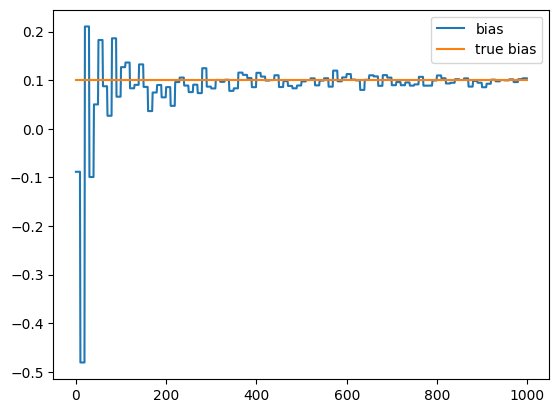

In [21]:
# Define the system matrices
F = Ad

H = np.array(C)

# Process noise covariance
Q = np.diag([2, 1, 0])

# Measurement noise covariance
R = np.diag([[0.05], [0.05]])

# Initial state estimate
x_hat = np.array([[0], [.1], [0]])

# Initial error covariance
P = np.diag([1, 100, 1000])

record = np.zeros((len(p), 3))

# Kalman Filter loop
for i in range(len(p)):
    # Predict step
    x_hat = F @ x_hat + Bd * a[i]
    P = F @ P @ F.T + Q

    # Update step
    if i % end == 0:
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        x_hat = x_hat + K @ (yp[:, i].reshape(2, 1) - H @ x_hat)
        P = (np.eye(3) - K @ H) @ P

    record[i, :] = x_hat.T

# plt.figure(dpi=200)
plt.plot(p, label='position')
plt.plot(record[:, 0], label='estimated pos', linestyle='dashed')
# plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
plt.legend()
# velocity
plt.figure()
plt.plot(record[:, 1], label='velocity')
plt.plot(v, label='true velocity')
plt.legend()
plt.figure()
plt.plot(record[:, 2], label='bias')
plt.plot(np.ones(len(record))*a_bias, label='true bias')
plt.legend()